In [1]:
# For auto-reloading external modules see
# http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

import numpy
import observations.dimensions.two.sampling as observe
import matplotlib.pyplot as plt

from defaults.plot import *

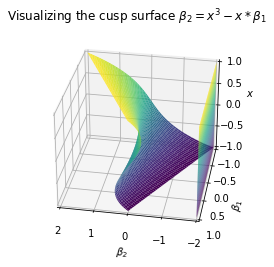

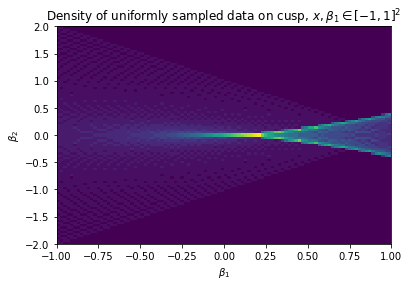

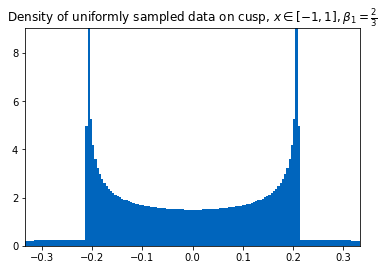

In [2]:
x_linespace = numpy.linspace(-1, 1, observe.samplesizex)
beta_1_linespace = numpy.linspace(-1, 1, observe.samplesizey)
X, beta_1 = numpy.meshgrid(x_linespace, beta_1_linespace)
beta_2 = observe.cusp_vectorized(X, beta_1)

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.set_title(r'Visualizing the cusp surface $\beta_2 = x^3 - x*\beta_1$')
ax.plot_surface(beta_2, beta_1, X, cmap='viridis', edgecolor='none', rasterized=True)
ax.plot_surface(-2, beta_1, X, cmap='viridis', edgecolor='none', rasterized=True)
ax.set_xlabel(r'$\beta_2$')
ax.set_ylabel(r'$\beta_1$')
ax.set_zlabel('$x$')
ax.azim = 100
ax.elev = 30
plt.show()

plt.title(r"Density of uniformly sampled data on cusp, $x, \beta_1 \in [-1, 1]^2$")
plt.hist2d(beta_1.reshape(-1), beta_2.reshape(-1), bins=100, density=True)
plt.xlabel(r"$\beta_1$")
plt.ylabel(r"$\beta_2$")
plt.show()

plt.title(r"Density of uniformly sampled data on cusp, $x \in [-1, 1], \beta_1 = \frac{2}{3} $")
plt.hist(observe.cusp_vectorized(numpy.linspace(-1, 1, 100000), numpy.repeat(2/3, 100000)), density=True, bins=150)
plt.show()

# TODO: three dimensional density of 2d data?

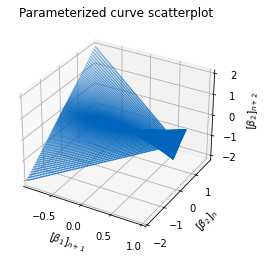

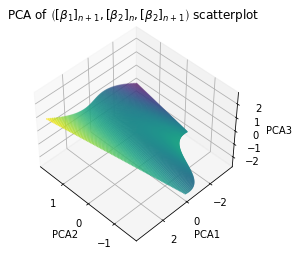

In [3]:
ys = observe.sample_beta_dir()

ax = plt.axes(projection='3d')
ax.scatter(numpy.transpose(ys)[0], numpy.transpose(ys)[1], numpy.transpose(ys)[2], s=0.5)
ax.set_xlabel("$[\\beta_1]_{n+1}$")
ax.set_ylabel("$[\\beta_2]_{n}$")
ax.set_zlabel("$[\\beta_2]_{n+2}$")
plt.title("Parameterized curve scatterplot")
plt.show()

from sklearn.decomposition import PCA
pca = PCA()
pca.n_components = 3

data = pca.fit_transform(ys)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_fit = scaler.fit_transform(data)

ax = plt.axes(projection='3d')
plt.title("PCA of $\\left([\\beta_1]_{n+1}, [\\beta_2]_n, [\\beta_2]_{n+1}\\right)$ scatterplot")
ax.scatter(numpy.transpose(data_fit)[1], numpy.transpose(data_fit)[0], numpy.transpose(data_fit)[2], c=numpy.transpose(data_fit)[0], cmap='viridis', s = 0.5, rasterized=True)
ax.set_xlabel("PCA2")
ax.set_ylabel("PCA1")
ax.set_zlabel("PCA3")
ax.azim = 135
ax.elev = 45
plt.show()

In [4]:
%%time

import datafold.pcfold as pfold

X_pcm = pfold.PCManifold(data_fit)
X_pcm.optimize_parameters()

print(f"epsilon={X_pcm.kernel.epsilon}, cut-off={X_pcm.cut_off}")

epsilon=0.008063394324523052, cut-off=0.3854000681949039
Wall time: 5.29 s


Found parsimonious eigenvectors (indices): [1 2]
TODO!


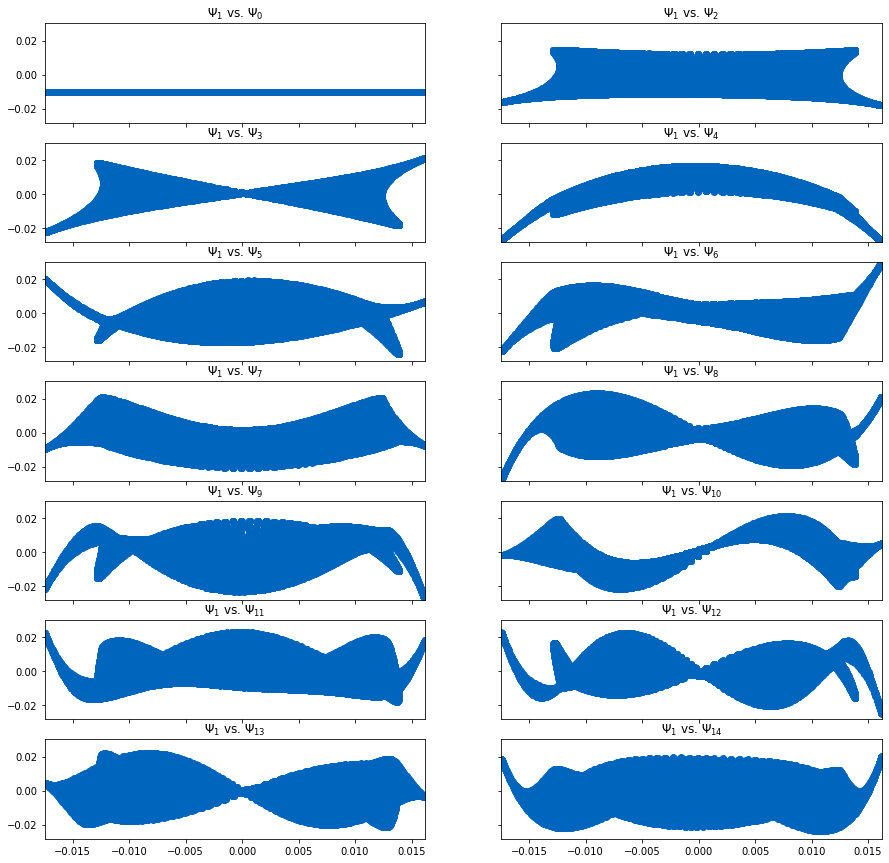

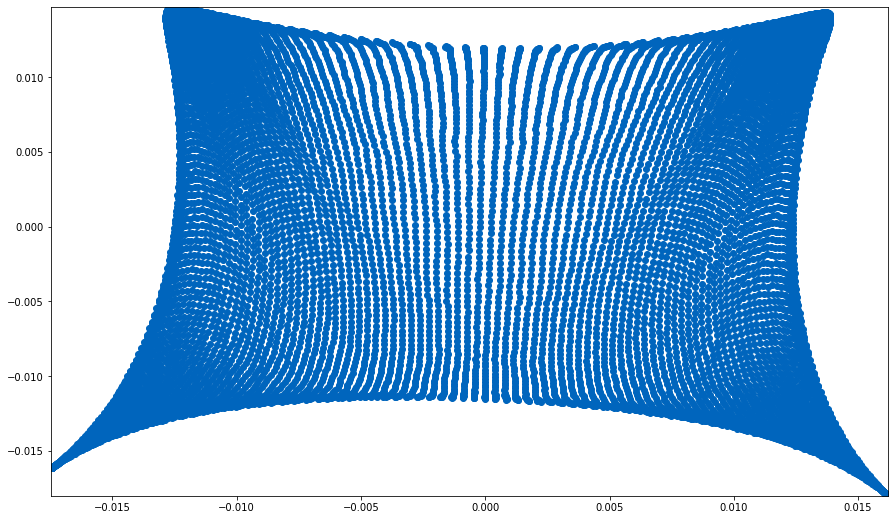

Wall time: 1min 41s


In [5]:
%%time

import datafold.dynfold as dfold

# TODO: also show this plot
#dmap = dfold.DiffusionMaps(
#    kernel=pfold.GaussianKernel(epsilon=X_pcm.kernel.epsilon),
#    n_eigenpairs=15,
#    dist_kwargs=dict(cut_off=X_pcm.cut_off),
#)
dmap = dfold.DiffusionMaps(
    kernel=pfold.ContinuousNNKernel(k_neighbor=125, delta=1.0),
    n_eigenpairs=15
)
dmap = dmap.fit(X_pcm)
evecs, evals = dmap.eigenvectors_, dmap.eigenvalues_

from datafold.utils.plot import plot_pairwise_eigenvector

plot_pairwise_eigenvector(
    eigenvectors=dmap.eigenvectors_,
    n=1,
    fig_params=dict(figsize=[15, 15]),
    scatter_params=dict(cmap=plt.cm.Spectral),
)

from datafold.dynfold import LocalRegressionSelection

selection = LocalRegressionSelection(
    intrinsic_dim=2, n_subsample=2500, strategy="dim"
).fit(dmap.eigenvectors_)
print(f"Found parsimonious eigenvectors (indices): {selection.evec_indices_}")

# ! TODO: change to transportation of everything (see jupyter demo 5 psi_all = ...)
#!!!!
print("TODO!")
target_mapping = selection.transform(dmap.eigenvectors_)

f, ax = plt.subplots(figsize=(15, 9))
ax.scatter(
    target_mapping[:, 0],
    target_mapping[:, 1],
    cmap=plt.cm.Spectral,
)
plt.show()

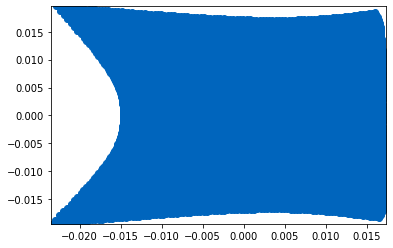

In [6]:
from functools import partial
from sklearn import manifold

LLE = partial(manifold.LocallyLinearEmbedding,
              n_neighbors=10, n_components=2, eigen_solver='auto')

Y = LLE(method='modified').fit_transform(data_fit)
#Y = manifold.Isomap(n_neighbors=10, n_components=2).fit_transform(data_fit)
#Y = manifold.MDS(n_components=2, max_iter=100, n_init=1).fit_transform(data_fit)
plt.scatter(Y[:, 0], Y[:, 1])
plt.show()

In [7]:
%%time
import torch
import flows.utils as flows

flow_dist, spline_transform = flows.normal2d_to_samples(torch.tensor(target_mapping, dtype=torch.float), steps=2001, normalize=True)

C:\Users\plain\Dropbox\university\21SS\IN2261 Bachelor's Thesis\code\demos\flows\utils.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = torch.tensor(data, dtype=torch.float)


step: 0, loss: -4.968729496002197
step: 200, loss: -7.377951622009277
step: 400, loss: -7.529853343963623
step: 600, loss: -7.577739715576172
step: 800, loss: -7.608211040496826
step: 1000, loss: -7.576179504394531
step: 1200, loss: -7.5682172775268555
step: 1400, loss: -7.62635612487793
step: 1600, loss: -7.609724044799805
step: 1800, loss: -7.571411609649658
step: 2000, loss: -7.65772819519043
Wall time: 2min 9s


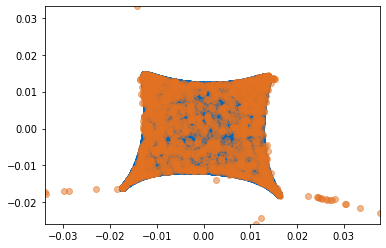

In [8]:
X_flow = flow_dist.sample(torch.Size([2000,])).detach().numpy()
plt.scatter(target_mapping[:, 0], target_mapping[:, 1])
plt.scatter(X_flow[:, 0], X_flow[:,1], alpha=0.5)
plt.show()

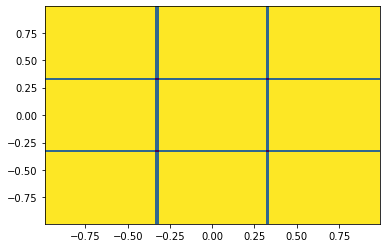

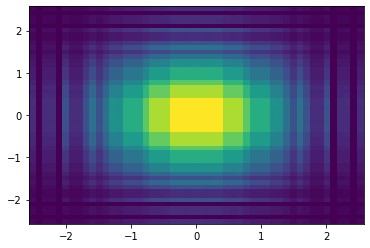

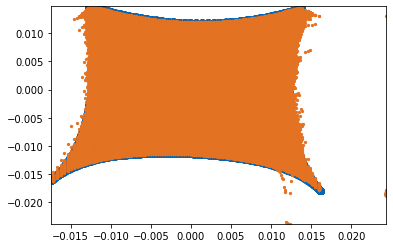

In [92]:
from scipy.special import erfinv
Gauss = lambda x, mu, sigma: mu + numpy.sqrt(2)*sigma*erfinv(2*x-1)
standard_gauss = numpy.vectorize(lambda x: Gauss((x + 1) / 2, 0, 1)) # multiple with 2 subtract one to transport 0 - 1 to -1, 1


x_linespace = numpy.linspace(-1, 1, observe.samplesizex*2)[1:-1]
beta_1_linespace = numpy.linspace(-1, 1, observe.samplesizey*2)[1:-1]
X, beta_1 = numpy.meshgrid(x_linespace, beta_1_linespace)

plt.hist2d(X.reshape(-1), beta_1.reshape(-1), bins=100)
plt.show()

normal_X, normal_beta_1 = numpy.meshgrid(standard_gauss(x_linespace), standard_gauss(beta_1_linespace))
plt.hist2d(normal_X.reshape(-1), normal_beta_1.reshape(-1), bins=50, density=True)
plt.show()

normal_point_tuples = numpy.array((normal_X, normal_beta_1)).reshape(2,-1).T#numpy.vstack([X.ravel(), beta_1.ravel()])
parameterized_space = spline_transform(torch.tensor(normal_point_tuples, dtype=torch.float)).detach().numpy()

plt.scatter(target_mapping[:, 0], target_mapping[:, 1])
plt.scatter(parameterized_space[:, 0], parameterized_space[:, 1], s=5, alpha=1)
plt.show()

In [ ]:
# Ok, now we have transformed a uniform distribution to the embedded space
# We can now reconstruct the fold by learning a way back from this embedding into the original space
# (could have been immediately)




Now we look at the joint distribution based on the marginals

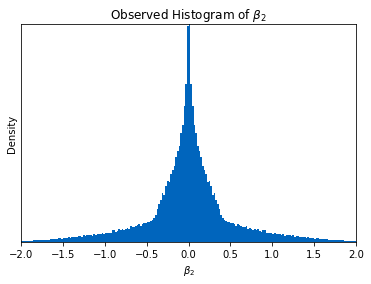

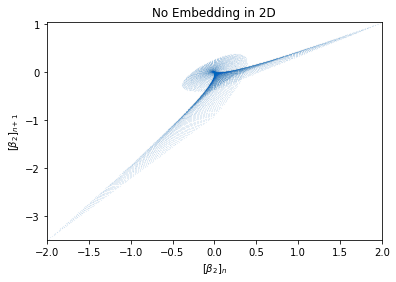

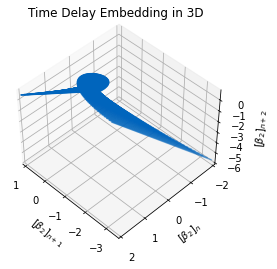

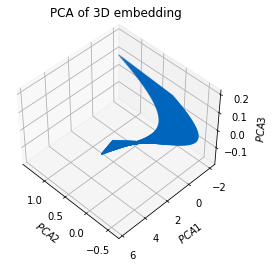

In [9]:
beta_2s = observe.sample_beta_2()

plt.hist(numpy.transpose(beta_2s)[0], bins=200, density=True)
plt.title(r"Observed Histogram of $\beta_2$")
plt.xlabel(r"$\beta_2$")
plt.ylabel("Density")
no_axis(x=True)
plt.show()

plt.scatter(numpy.transpose(beta_2s)[0], numpy.transpose(beta_2s)[1], s = 0.001)
plt.title("No Embedding in 2D")
plt.xlabel(r"$[\beta_2]_{n}$")
plt.ylabel(r"$[\beta_2]_{n+1}$")
plt.show()

ax = plt.axes(projection='3d')
ax.scatter(numpy.transpose(beta_2s)[1], numpy.transpose(beta_2s)[0], numpy.transpose(beta_2s)[2], s = 0.5)
plt.title("Time Delay Embedding in 3D")
ax.set_xlabel(r"$[\beta_2]_{n+1}$")
ax.set_ylabel(r"$[\beta_2]_{n}$")
ax.set_zlabel(r"$[\beta_2]_{n+2}$")
ax.azim = 135
ax.elev = 45
plt.show()

from sklearn.decomposition import PCA
pca = PCA()
pca.n_components = 3

data = pca.fit_transform(beta_2s)

ax = plt.axes(projection='3d')
ax.scatter(numpy.transpose(data)[1], numpy.transpose(data)[0], numpy.transpose(data)[2], s = 0.5)
plt.title("PCA of 3D embedding")
ax.set_xlabel("$PCA2$")
ax.set_ylabel("$PCA1$")
ax.set_zlabel("$PCA3$")
ax.azim = 135
ax.elev = 45
plt.show()